# Hands-on ML with Python 
# Chapter 02: End-to-End ML Project

Using `sklearn` to predict the median price of houses in California using the California `StatLib` dataset. 

## Setup

In [1]:
# For access to linker/compiler functionality
import sys
assert sys.version_info >= (3, 5)

# Sklearn for creating ML models
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os 

# For plotting pretty figures with matplotlib
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save figures in a separate subdirectory
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", " ")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save matplotlib images as PNGs 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

## Get the Data
Will write a small function that makes a request to a URL and downloads the latest version of the dataset as a `tgz` file with the dataset's CSV. While this can be done manually, writing a small function to do this can be useful if
- the data changes frequently and has to be fetched on a recurring basis.
- the data has to be downloaded on multiple machines.

In [3]:
import os 
import tarfile
from six.moves import urllib

In [8]:
# Defining filepaths and URLs as constants that will be used to fetch data
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' 

In [11]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    # If the datasets dir does not exist yet, make the dir
    if not os.path.isdir(housing_path):
        os.mkdirs(housing_path)
    
    # The TGZ file will be downloaded to the housing dataset folder as `housing.tgz`
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    
    # Make a request to the URL to download the file to the right location
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # Open, extract, and close the tgz file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [12]:
fetch_housing_data()

## Load the Data with `pandas`

In [13]:
import pandas as pd

In [14]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [15]:
housing = load_housing_data()

## Initial Data Analysis

In [16]:
# Examine the first few rows in the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [17]:
# A summary of the number of attributes in each column - to help identify missing values
# Along with their data types and names
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- `total_bedrooms` has only 20,433 values while all others have 20,640 values. This mean there $20,640 - 20,433 = 207$ missing values in this column, which we will have to deal with later.
- `ocean_proximity` is of type `object`, which means it is most likely text (since the data was loaded from a CSV). ML models can only work with numeric data, so `ocean_proximity` will have to be converted to a numeric variable (categorical numeric variable). 

In [21]:
# How many houses are NEAR BAY, INLAND, NEAR OCEAN, or on an ISLAND?
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [22]:
# describe shows statistical summary of each numerical attribute
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


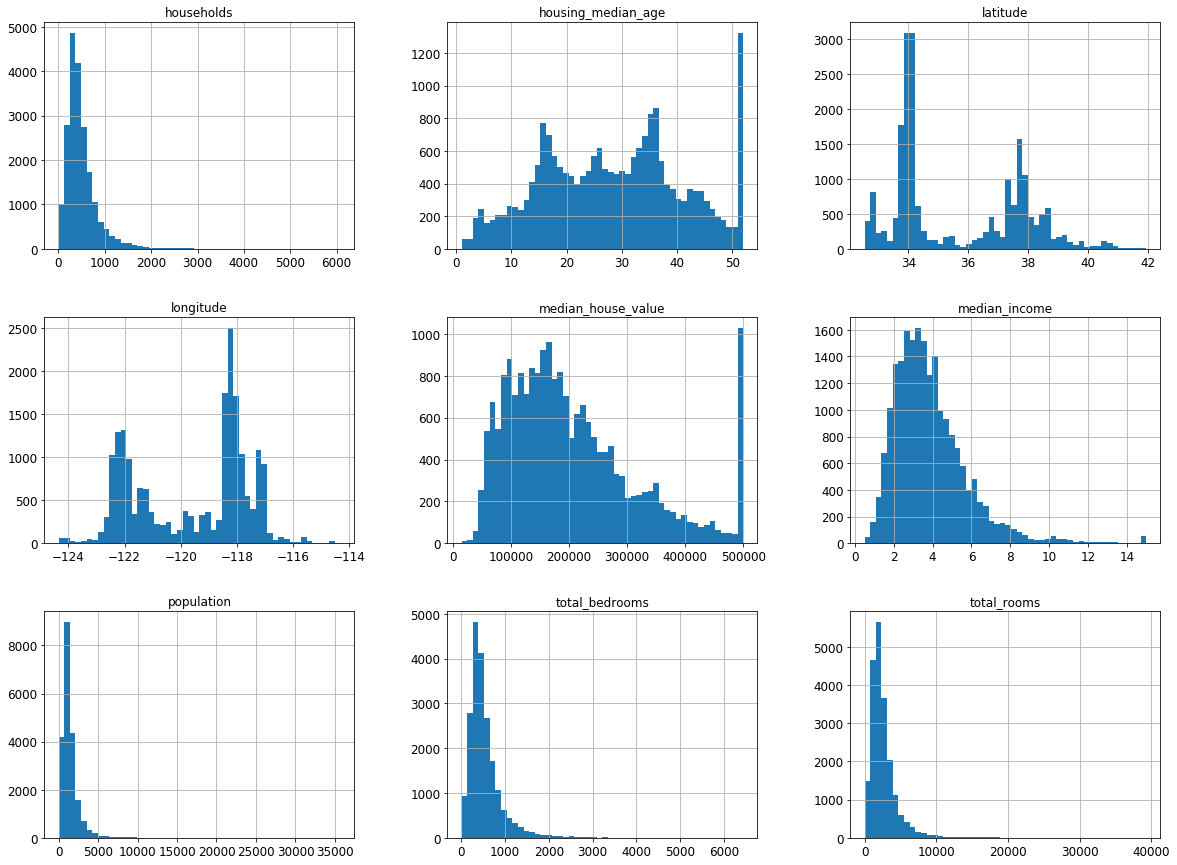

Saving figure  feature_histograms


<Figure size 432x288 with 0 Axes>

In [91]:
# Configuring matplotlib to use Jupyter's backend for generating plots and to display all plots in notebook
%matplotlib inline

# Plotting histograms for all numeric data to visualize trends/distribution
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()
save_fig('feature_histograms')

- A lot of these features are tail heavy or have fat tailed distributions. This means they extend much farther to the right than to the left of the median. This can be a problem for some ML algos, and we will have to standardise these features.
- `median_house_value` was capped at 500k, which is why the histogram for this feature shows a spike at 500k. This is a problem, because this is actually the target that we will try to predict.
    - If we want to include these samples in the training data, we will have to find the right labels for these samples.
    - If we can't get correct labels, we should remove them from the training set and test set.
- All features have very different ranges of values, and must be scaled to occupy the same range of values e.g. 0 - 1, or -1 to 1.
- `median_income` was not measured in dollars (see the x-axis). It was scaled and mapped to a range of 15 for max and 0.5 for min incomes. This may not be a problem, but it helps to understand how the data has been preprocessed.

## Create Test Set

In [30]:
import numpy as np

# seed the random number generator to match the book's results
# Also to ensure that the same random list of train/test indices are achieved every time 
# the program is run
np.random.seed(42)

In [28]:
# Defining our own function to split the data into train/test sets
# This is very similar to what `sklearn` does
def split_train_test(data, test_ratio):
    # Use the length of the data to return a randomly permuted range of indices
    shuffled_indices = np.random.permutation(len(data))
    
    # Number of samples in the test set must be a whole number or integer
    test_set_size = int(len(data) * test_ratio)
    
    # The first `test_set_size` indices in the randomly shuffled list of indices are for the test set
    test_indices = shuffled_indices[:test_set_size]
    
    # The remaining indices are for the training set
    train_indices = shuffled_indices[test_set_size:]
    
    # Find the rows at the specified indices for training and test data and return them
    # iloc means using a row's indexed-based location in the dataset
    return data.iloc[train_indices], data.iloc[test_indices]

In [29]:
train_set, test_set = split_train_test(housing, 0.2)
print(f"Train set size:\t{len(train_set)}")
print(f"Test set size:\t{len(test_set)}")

Train set size:	16512
Test set size:	4128


## What's wrong with this approach?
- If we use a random number generator to fetch training/test data each time the program/notebook is run, it will fetch different data. 
    - This is bad because then our results will not be reproducible. 
    - Also, over time this will mean that the ML model will get to see the whole dataset.
- We could seed the random number generator or save the test set on the first run, and then load the test set on subsequent runs.
    - This avoids the problem of different train/test data being loaded each time. 
- However, this approach will break the moment the dataset is updated or we fetch new data. 

**Solution**: Use each sample's unique identifier to hash it. If the hash is lower than or equal to 20% of the maximum hash value, put it in the test set. Ensures test set will remain consistent across multiple runs, even if the dataset is refreshed. New test set will contain 20% of new instances, but not any instance that was previously in the training set.

## Hashing for Test Set
Had to use the third hash function - the one that works for both Python 2 and Python 3. The first hash function was causing issues because it was returning indices that weren't present in the `index` column in the dataset. Probably an error on my part, but I was not able to debug it.

In [79]:
import hashlib

In [75]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [76]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [77]:
housing_with_id = housing.reset_index() # Add an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [78]:
print(f"Training samples: {len(train_set)}")
print(f"Test samples: {len(test_set)}")

Training samples: 16362
Test samples: 4278


If we're using the `index` or the row number of a sample for hashing, we have to make sure that any new data is always added to the end of the dataset, and that no existing row is ever deleted.

For obvious reasons, this is difficult to do in practice. The solution is to use a feature that will be both unique and relatively stable across all examples in the foreseeable future. For instance, the latitude and longitude of a house will not change for a long time, so they can be used for creating an ID which can then be hashed.

In [81]:
# Now the ID column wil be a unique number which is a linear combination of the lat and long for that house
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

# Hash the id, and use the hashes to do a train/test split
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

## Train-Test split with `sklearn`

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
# Using the built-in function with the args for a training ratio as well as the random state for reproducibility
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Sampling
- So far we've been using random sampling for splitting data into train and test sets.
- This isn't always the best idea, because there is no guarantee that samples in either set will be representative of the population i.e. they will be representative of all other houses in California.
- The solution is to use **stratified sampling**: divide the population into groups or strata, and then ensure that these strata are present in your samples in the same proportions as in the population.

We'll investigate this in the `median_income` attribute: are the values representative of other incomes in the dataset?

Should not have too many strata, and each strata should be large enough to not introduce bias. In the `median_income` histogram, some values are far larger than 60k, so we should restructure the strata in this column to be fewer and larger.

Using `pd.cut()` will encode `median_income` as a categorical variable that falls into one of 5 bins or strata.

In [84]:
housing['income_cat'] = pd.cut(housing['median_income'], 
                              bins=[0, 1.5, 3, 4.5, 6, np.inf], 
                              labels=[1, 2, 3, 4, 5])

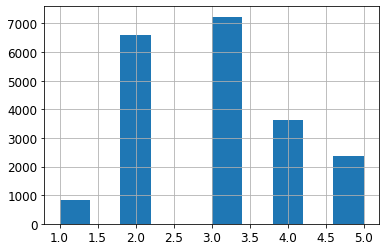

In [85]:
# Plot a histogram for the newly created categorical income feature
housing["income_cat"].hist()

## Stratified Sampling based on Income Category
Now that we have encoded the continuous `median_income` values into one of 5 categories, we can do stratified random sampling of the dataset based on the `median_income` to ensure each strata is proportionally represented in the training and test sets.

The reason we're doing this on the basis of the `median_income` column (and not other features) is because we've been told by domain experts that this is a very important feature in predicting housing prices. So it makes sense to ensure our sampling for the training/test sets helps minimize the effect of sampling bias on this feature's predictive power.

In [86]:
from sklearn.model_selection import StratifiedShuffleSplit

In [88]:
# Only 1 split (train/test) with 80% in train and 20% in test with random gen seeded at 42
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [89]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

To test if this worked, we can find the %age of all samples in the dataset that belong to each income category, and compare them with the original income_cat histogram.

In [95]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Can also plot these as histograms and visually inspect the distribution for similarity with the original training set.

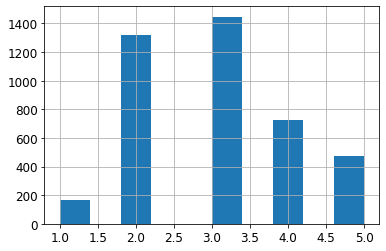

In [98]:
strat_test_set['income_cat'].hist()

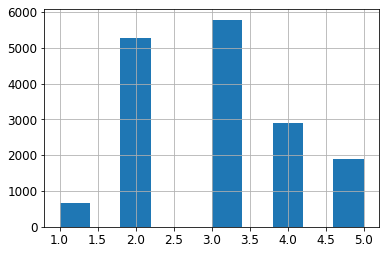

In [99]:
strat_train_set['income_cat'].hist()

Can compare the error in the proportions of each category between the full dataset and the test set using a function that makes a new dataframe. Can also use this to confirm that simply using a `train_test_split` will create a larger statified sampling error.

In [100]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

# Uses our own implementation of unstratified train/test split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# Create a new dataframe with columns that show proportions of each income category in three diff sets
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing), 
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

# Create columns that show errors in random and stratified set proportions relative to original dataset
compare_props['Rand %age Error'] =  100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Stratified %age Error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

In [101]:
compare_props

,Overall,Stratified,Random,Rand %age Error,Stratified %age Error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Removing the `income_cat` column from the dataset. We don't need it anymore as we're now done with the stratified sampling.

In [102]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)